In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
pd.options.display.max_columns = None

In [2]:
PATH_DATA_RAW= '../Dataset/Raw/'
PATH_DATA_CLEAN = '../Dataset/Clean/'

In [3]:
df = joblib.load(PATH_DATA_CLEAN+'dataset_modeling_hour.pkl')
df.head()

,call_time,total_trip,holiday,is_weekend
0,2019-05-01 16:00:00,1,1,0
1,2019-05-02 22:00:00,3,0,0
2,2019-05-02 23:00:00,342,0,0
3,2019-05-03 00:00:00,988,0,0
4,2019-05-03 01:00:00,899,0,0


# Cut data and Convert to Time Series Index

In [4]:
df = df.drop([0,1,2])
df.set_index('call_time', inplace=True)
df.head()

,total_trip,holiday,is_weekend
call_time,,,
2019-05-03 00:00:00,988,0,0
2019-05-03 01:00:00,899,0,0
2019-05-03 02:00:00,856,0,0
2019-05-03 03:00:00,933,0,0
2019-05-03 04:00:00,987,0,0


In [5]:
df = df.asfreq('H')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3456 entries, 2019-05-03 00:00:00 to 2019-09-23 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   total_trip  3456 non-null   int64
 1   holiday     3456 non-null   int64
 2   is_weekend  3456 non-null   int64
dtypes: int64(3)
memory usage: 108.0 KB


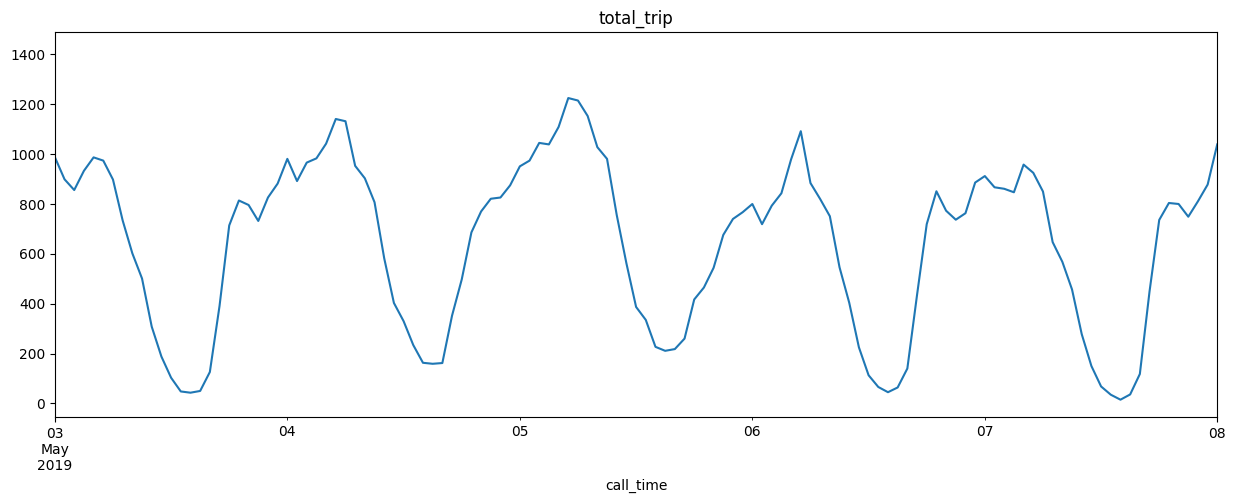

In [6]:
from datetime import datetime
df.total_trip.plot(figsize=(15,5),title = "total_trip")
# Batasi rentang sumbu x mulai dari tanggal tertentu
start_date = datetime.strptime('2019-05-03', '%Y-%m-%d')
end_date = datetime.strptime('2019-05-08', '%Y-%m-%d')
plt.xlim(start_date, end_date)
plt.show()

In [7]:
size = int(len(df)*0.8)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

# SARIMA and SARIMAX

## Cek komponen deret waktu

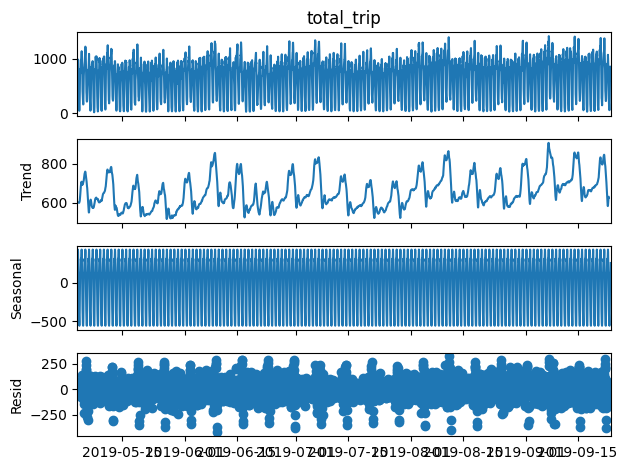

<Figure size 2000x500 with 0 Axes>

In [8]:
import statsmodels.api as sm
dec = sm.tsa.seasonal_decompose(df['total_trip'], period = 24, model = 'additive').plot()
plt.figure(figsize=(20,5))
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=24).mean()
    MSTD = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    start_date = datetime.strptime('2019-05-03', '%Y-%m-%d')
    end_date = datetime.strptime('2019-05-08', '%Y-%m-%d')
    plt.xlim(start_date, end_date)
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

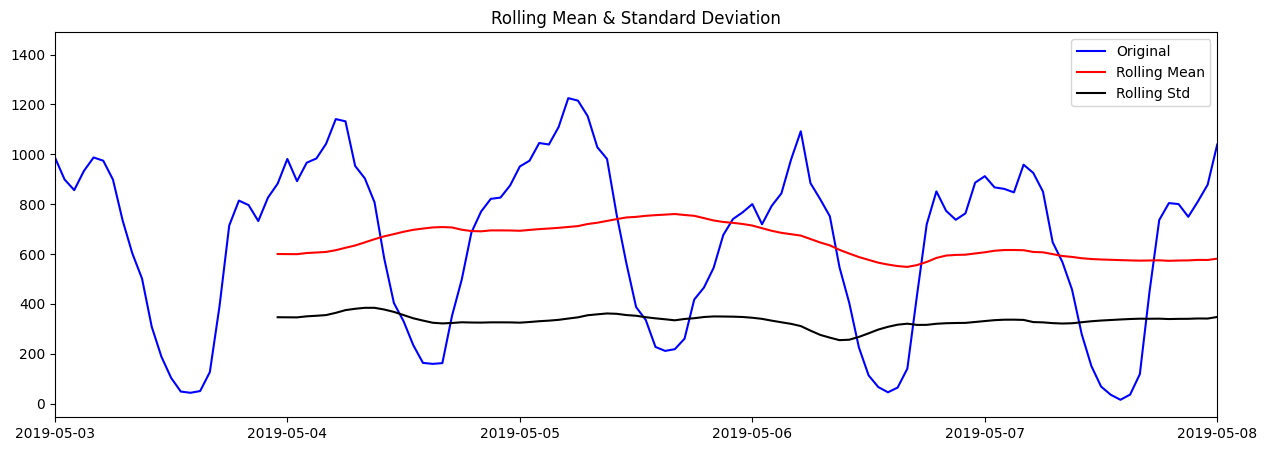

Results of Dickey-Fuller Test:
Test Statistic                -6.716846e+00
p-value                        3.564151e-09
#Lags Used                     3.000000e+01
Number of Observations Used    3.425000e+03
Critical Value (1%)           -3.432261e+00
Critical Value (5%)           -2.862384e+00
Critical Value (10%)          -2.567219e+00
dtype: float64


In [11]:
test_stationarity(df['total_trip'])

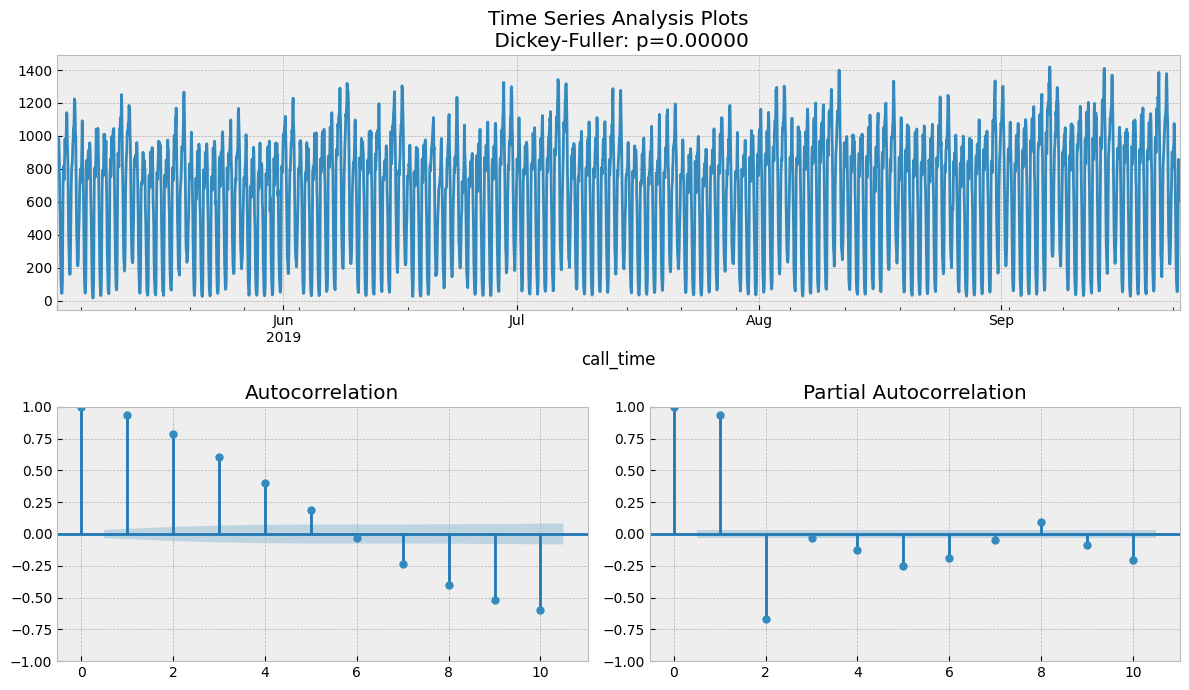

In [12]:
tsplot(df['total_trip'],lags = 10)

Orde:
* p: [0,1,2]
* d: 0
* q: [0,1,2]

## Menghilangkan efek seasonal

In [13]:
# Lakukan differencing musiman pada variabel endogen dengan periode 24 (harian dalam jam)
df1_log_diff_seas = df['total_trip'].diff(24)

# Buat DataFrame baru untuk menyimpan hasil differencing
df_diff_seas = pd.DataFrame({
    'total_trip_diff': df1_log_diff_seas,
    'holiday': df['holiday'],
    'is_weekend': df['is_weekend']
})
# Hapus baris yang mengandung nilai NaN
df_diff_seas = df_diff_seas.dropna()

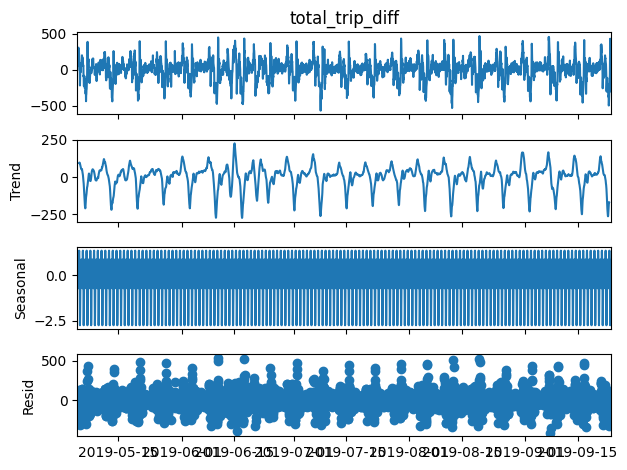

In [14]:
# Tampilkan plot decompose
dec = sm.tsa.seasonal_decompose(df_diff_seas['total_trip_diff']).plot()
plt.show()

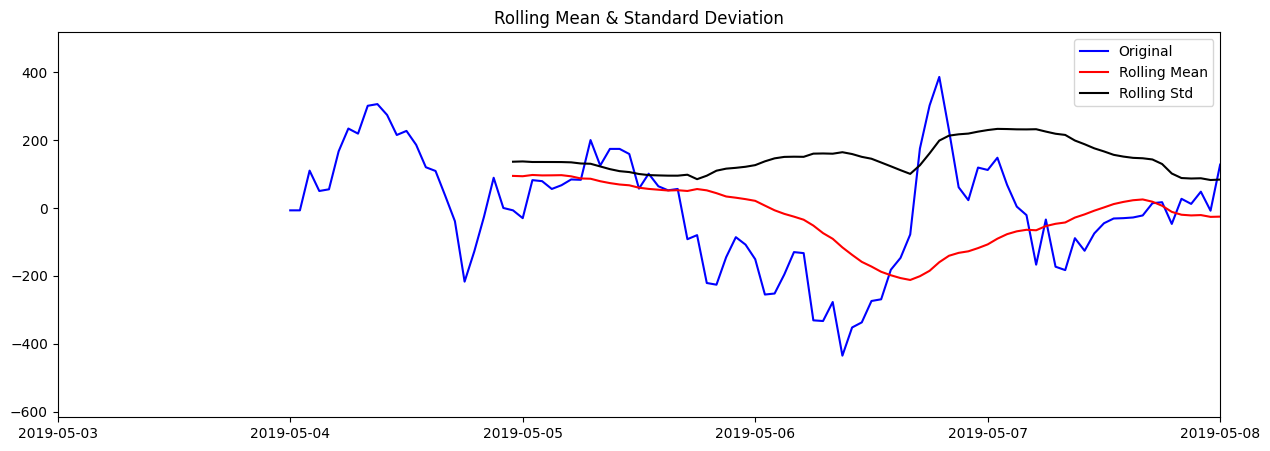

Results of Dickey-Fuller Test:
Test Statistic                -9.263107e+00
p-value                        1.389912e-15
#Lags Used                     3.000000e+01
Number of Observations Used    3.401000e+03
Critical Value (1%)           -3.432274e+00
Critical Value (5%)           -2.862390e+00
Critical Value (10%)          -2.567223e+00
dtype: float64


In [15]:
test_stationarity(df_diff_seas['total_trip_diff'])

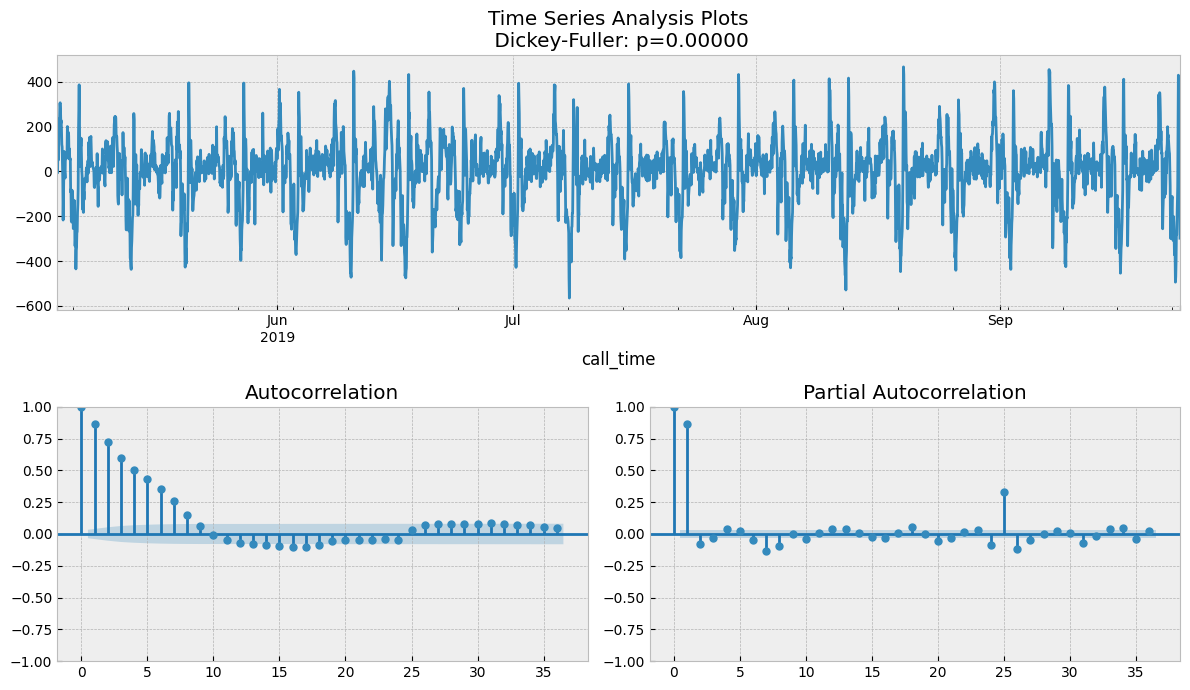

In [16]:
tsplot(df_diff_seas['total_trip_diff'])

Orde Seasonal:
* p: [0,1,2]
* d: 0
* q: [0,1,2]
* s: 24 (24 jam)

## Orde model yang akan tuning

In [17]:
# Orde Non Seasonal
p = [0,1,2] # Orde AR
d = 0
q = [0,1,2] # Orde MA

# Orde Seasonal
P = [0,1,2] # Orde AR Seasonal
D = 0
Q = [0,1,2] # Orde MA Seasonal
s = 24 #(24 jam)

# Model SARIMA

In [18]:
import itertools
from sklearn.metrics import mean_squared_error
import time

# Gabungkan semua kombinasi nilai parameter
param_combinations = list(itertools.product(p, q, P, Q))
total_comb = len(p)*1*len(q)*len(P)*1*len(Q)
print(f"Total kombinasi model: {total_comb} kombinasi")

best_score = float("inf")
best_params = None
no = 1
# Lakukan grid search untuk setiap kombinasi parameter
for param in param_combinations:
    try:
        start_time = time.time()
        # Buat dan latih model SARIMA dengan musiman setiap 24 jam
        print(f"{no}. Model: SARIMA({param[0]},{d},{param[1]})({param[2]},{D},{param[3]}){s}"); no += 1
        model = sm.tsa.SARIMAX(df_train['total_trip'], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 24))
        results = model.fit()
        elapsed_time = time.time() - start_time
        if elapsed_time > 120:  # Jika waktu pelatihan melebihi 2 menit (120 detik)
            print("Waktu pelatihan melebihi batas 2 menit, melanjutkan ke parameter selanjutnya...")
            print("==================================================================================")
            continue   
        prediksi = results.predict(start=df_train.index[0], end=df_train.index[-1])
        mse = mean_squared_error(df_train['total_trip'], prediksi)
        rmse = np.sqrt(mse)
        print(f"Nilai RMSE: {rmse}")
        print(f"Duration: {elapsed_time}")
        print("==================================================================================")
        if rmse < best_score:
            best_score = rmse
            best_params = param
    
    except Exception as e:
        print("Model ini eror:", e)
        elapsed_time = time.time() - start_time
        print(f"Duration: {elapsed_time}")
        print("==================================================================================")
        continue

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

Total kombinasi model: 81 kombinasi
1. Model: SARIMA(0,0,0)(0,0,0)24
Nilai RMSE: 729.6799796132108
Duration: 0.01815962791442871
2. Model: SARIMA(0,0,0)(0,0,1)24
Nilai RMSE: 413.5708083443897
Duration: 1.3189074993133545
3. Model: SARIMA(0,0,0)(0,0,2)24
Nilai RMSE: 297.79686923498997
Duration: 10.172300100326538
4. Model: SARIMA(0,0,0)(1,0,0)24
Nilai RMSE: 151.9109385096668
Duration: 0.21863555908203125
5. Model: SARIMA(0,0,0)(1,0,1)24
Nilai RMSE: 142.65663683245467
Duration: 3.526111125946045
6. Model: SARIMA(0,0,0)(1,0,2)24
Nilai RMSE: 129.10938245757902
Duration: 28.812235832214355
7. Model: SARIMA(0,0,0)(2,0,0)24
Nilai RMSE: 151.75289850997177
Duration: 1.2081122398376465
8. Model: SARIMA(0,0,0)(2,0,1)24
Nilai RMSE: 134.46218409715027
Duration: 26.750917196273804
9. Model: SARIMA(0,0,0)(2,0,2)24
Nilai RMSE: 128.9122208337687
Duration: 27.205003261566162
10. Model: SARIMA(0,0,1)(0,0,0)24
Nilai RMSE: 390.9635559186793
Duration: 0.1651170253753662
11. Model: SARIMA(0,0,1)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 239.10594686056356
Duration: 3.5999763011932373
12. Model: SARIMA(0,0,1)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 178.42024698832006
Duration: 13.604445695877075
13. Model: SARIMA(0,0,1)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 176.50377850863234
Duration: 2.7118425369262695
14. Model: SARIMA(0,0,1)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Waktu pelatihan melebihi batas 2 menit, melanjutkan ke parameter selanjutnya...
15. Model: SARIMA(0,0,1)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 216.4227446699027
Duration: 14.92533540725708
16. Model: SARIMA(0,0,1)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 7207.4558057818795
Duration: 17.074477195739746
17. Model: SARIMA(0,0,1)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 158.3142885121981
Duration: 45.18461847305298
18. Model: SARIMA(0,0,1)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 729.6799796132108
Duration: 24.030790328979492
19. Model: SARIMA(0,0,2)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 240.15470370609992
Duration: 0.6078033447265625
20. Model: SARIMA(0,0,2)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 295.6875599340151
Duration: 6.2700135707855225
21. Model: SARIMA(0,0,2)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 260.5508103463652
Duration: 44.331597089767456
22. Model: SARIMA(0,0,2)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 86.92951790386427
Duration: 4.546706199645996
23. Model: SARIMA(0,0,2)(1,0,1)24
Nilai RMSE: 221.87078841514722
Duration: 8.897237300872803
24. Model: SARIMA(0,0,2)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 170.84023945356807
Duration: 55.76199293136597
25. Model: SARIMA(0,0,2)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 729.6799796132108
Duration: 20.6502525806427
26. Model: SARIMA(0,0,2)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model ini eror: LU decomposition error.
Duration: 25.882683753967285
27. Model: SARIMA(0,0,2)(2,0,2)24
Model ini eror: LU decomposition error.
Duration: 77.88705587387085
28. Model: SARIMA(1,0,0)(0,0,0)24
Nilai RMSE: 125.9227340321435
Duration: 0.18613290786743164
29. Model: SARIMA(1,0,0)(0,0,1)24
Nilai RMSE: 94.34359788834738
Duration: 0.9992935657501221
30. Model: SARIMA(1,0,0)(0,0,2)24
Nilai RMSE: 84.30584678141783
Duration: 6.148212671279907
31. Model: SARIMA(1,0,0)(1,0,0)24
Nilai RMSE: 71.5341910335557
Duration: 1.1372699737548828
32. Model: SARIMA(1,0,0)(1,0,1)24
Nilai RMSE: 61.12564256833665
Duration: 4.571156740188599
33. Model: SARIMA(1,0,0)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 59.78287133656209
Duration: 49.01532340049744
34. Model: SARIMA(1,0,0)(2,0,0)24
Nilai RMSE: 69.31253373307528
Duration: 4.480180263519287
35. Model: SARIMA(1,0,0)(2,0,1)24
Nilai RMSE: 60.07154704253229
Duration: 29.475130558013916
36. Model: SARIMA(1,0,0)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 61.723178407134874
Duration: 47.82735085487366
37. Model: SARIMA(1,0,1)(0,0,0)24
Nilai RMSE: 104.88268330172716
Duration: 0.2183694839477539
38. Model: SARIMA(1,0,1)(0,0,1)24
Nilai RMSE: 87.9765219651147
Duration: 1.303447961807251
39. Model: SARIMA(1,0,1)(0,0,2)24
Nilai RMSE: 81.37715519437751
Duration: 6.235141754150391
40. Model: SARIMA(1,0,1)(1,0,0)24
Nilai RMSE: 71.23311531244565
Duration: 2.0597283840179443
41. Model: SARIMA(1,0,1)(1,0,1)24
Nilai RMSE: 60.44329267882
Duration: 5.365210294723511
42. Model: SARIMA(1,0,1)(1,0,2)24
Nilai RMSE: 59.35470467542118
Duration: 30.85164213180542
43. Model: SARIMA(1,0,1)(2,0,0)24
Nilai RMSE: 68.66661513787129
Duration: 7.045815944671631
44. Model: SARIMA(1,0,1)(2,0,1)24
Nilai RMSE: 59.87023573512854
Duration: 23.199371337890625
45. Model: SARIMA(1,0,1)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 60.579528614852315
Duration: 93.09763264656067
46. Model: SARIMA(1,0,2)(0,0,0)24
Nilai RMSE: 99.61728675026198
Duration: 0.26619720458984375
47. Model: SARIMA(1,0,2)(0,0,1)24
Nilai RMSE: 85.61460000821647
Duration: 1.6340196132659912
48. Model: SARIMA(1,0,2)(0,0,2)24
Nilai RMSE: 80.14499825398731
Duration: 7.951867341995239
49. Model: SARIMA(1,0,2)(1,0,0)24
Nilai RMSE: 71.11715007684657
Duration: 2.8601062297821045
50. Model: SARIMA(1,0,2)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 60.310874968435726
Duration: 11.305027723312378
51. Model: SARIMA(1,0,2)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 59.26540593037146
Duration: 46.24766564369202
52. Model: SARIMA(1,0,2)(2,0,0)24
Nilai RMSE: 68.51046383230874
Duration: 10.736322164535522
53. Model: SARIMA(1,0,2)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 59.624146625421446
Duration: 38.518872022628784
54. Model: SARIMA(1,0,2)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Waktu pelatihan melebihi batas 2 menit, melanjutkan ke parameter selanjutnya...
55. Model: SARIMA(2,0,0)(0,0,0)24
Nilai RMSE: 99.06043801482963
Duration: 0.0829932689666748
56. Model: SARIMA(2,0,0)(0,0,1)24
Nilai RMSE: 85.45067834685553
Duration: 1.2001807689666748
57. Model: SARIMA(2,0,0)(0,0,2)24
Nilai RMSE: 80.24440970304072
Duration: 7.111273288726807
58. Model: SARIMA(2,0,0)(1,0,0)24
Nilai RMSE: 71.20098561561183
Duration: 1.6715993881225586
59. Model: SARIMA(2,0,0)(1,0,1)24
Nilai RMSE: 60.34669000265532
Duration: 5.5231451988220215
60. Model: SARIMA(2,0,0)(1,0,2)24
Nilai RMSE: 59.31487693233522
Duration: 36.95698618888855
61. Model: SARIMA(2,0,0)(2,0,0)24
Nilai RMSE: 68.5912770528681
Duration: 6.166255235671997
62. Model: SARIMA(2,0,0)(2,0,1)24
Nilai RMSE: 59.83165619732173
Duration: 23.72010588645935
63. Model: SARIMA(2,0,0)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 60.215477193785254
Duration: 98.56335163116455
64. Model: SARIMA(2,0,1)(0,0,0)24
Nilai RMSE: 98.78332823602662
Duration: 0.1358482837677002
65. Model: SARIMA(2,0,1)(0,0,1)24
Nilai RMSE: 85.34268800759757
Duration: 1.8218228816986084
66. Model: SARIMA(2,0,1)(0,0,2)24
Nilai RMSE: 80.05002789978548
Duration: 8.104241371154785
67. Model: SARIMA(2,0,1)(1,0,0)24
Nilai RMSE: 70.96669152128021
Duration: 6.9686830043792725
68. Model: SARIMA(2,0,1)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 60.5400641407787
Duration: 9.512056112289429
69. Model: SARIMA(2,0,1)(1,0,2)24
Nilai RMSE: 60.02551374299956
Duration: 60.31256628036499
70. Model: SARIMA(2,0,1)(2,0,0)24
Nilai RMSE: 69.31352219770838
Duration: 5.631336212158203
71. Model: SARIMA(2,0,1)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 59.79188656058064
Duration: 37.46805286407471
72. Model: SARIMA(2,0,1)(2,0,2)24
Nilai RMSE: 61.341528022713504
Duration: 44.96284604072571
73. Model: SARIMA(2,0,2)(0,0,0)24
Nilai RMSE: 98.66888508904727
Duration: 0.3021118640899658
74. Model: SARIMA(2,0,2)(0,0,1)24
Nilai RMSE: 85.31616075915778
Duration: 2.6636180877685547
75. Model: SARIMA(2,0,2)(0,0,2)24
Nilai RMSE: 80.02657594831645
Duration: 11.740129947662354
76. Model: SARIMA(2,0,2)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 70.45054239297212
Duration: 4.265603542327881
77. Model: SARIMA(2,0,2)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 60.61205836209049
Duration: 11.769452571868896
78. Model: SARIMA(2,0,2)(1,0,2)24
Nilai RMSE: 59.70132735781005
Duration: 48.528828620910645
79. Model: SARIMA(2,0,2)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 68.31556960772063
Duration: 16.230844020843506
80. Model: SARIMA(2,0,2)(2,0,1)24
Nilai RMSE: 59.8477010795261
Duration: 43.09881258010864
81. Model: SARIMA(2,0,2)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Waktu pelatihan melebihi batas 2 menit, melanjutkan ke parameter selanjutnya...
Best Parameters: (1, 2, 1, 2)
Best RMSE: 59.26540593037146


### **MODEL TERBAIK**: SARIMA(1,0,2)(1,0,2)24

# Model SARIMAX

In [19]:
best_score = float("inf")
best_params = None
no = 1
print(f"Total kombinasi model: {total_comb} kombinasi")

for param in param_combinations:
    try:
        start_time = time.time()
        # Buat dan latih model SARIMA dengan musiman setiap 24 jam
        print(f"{no}. Model: SARIMA({param[0]},{d},{param[1]})({param[2]},{D},{param[3]}){s}")
        no += 1
        model = sm.tsa.SARIMAX(df_train['total_trip'], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 24), exog=df_train[['holiday','is_weekend']])
        results = model.fit()
        elapsed_time = time.time() - start_time
        if elapsed_time > 180:  # Jika waktu pelatihan melebihi 3 menit (180 detik)
            print("Waktu pelatihan melebihi batas 3 menit, melanjutkan ke parameter selanjutnya...")
            print("===================================================================================")
            continue 
        prediksi = results.predict(start=df_train.index[0], end=df_train.index[-1], exog=df_train[['holiday', 'is_weekend']])
        mse = mean_squared_error(df_train['total_trip'], prediksi)
        rmse = np.sqrt(mse)
        print(f"Nilai RMSE: {rmse}")
        print(f"Duration: {elapsed_time}")
        print("===================================================================================")
        if rmse < best_score:
            best_score = rmse
            best_params = param
      
    except Exception as e:
        print("Model ini eror:", e)
        elapsed_time = time.time() - start_time
        print(f"Duration: {elapsed_time}")
        print("===================================================================================")
        continue

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

Total kombinasi model: 81 kombinasi
1. Model: SARIMA(0,0,0)(0,0,0)24
Nilai RMSE: 610.348663115961
Duration: 0.4214484691619873
2. Model: SARIMA(0,0,0)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 366.50843951081913
Duration: 4.6591877937316895
3. Model: SARIMA(0,0,0)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 281.9298130646175
Duration: 25.333158254623413
4. Model: SARIMA(0,0,0)(1,0,0)24
Model ini eror: LU decomposition error.
Duration: 5.399050235748291
5. Model: SARIMA(0,0,0)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 208.7006631605628
Duration: 26.390255451202393
6. Model: SARIMA(0,0,0)(1,0,2)24
Nilai RMSE: 278.9190886673767
Duration: 22.5811448097229
7. Model: SARIMA(0,0,0)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 139.36473859875062
Duration: 33.8678023815155
8. Model: SARIMA(0,0,0)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 140.75221066832373
Duration: 45.91544270515442
9. Model: SARIMA(0,0,0)(2,0,2)24
Nilai RMSE: 275.7468445712039
Duration: 31.435285806655884
10. Model: SARIMA(0,0,1)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 340.1607920674537
Duration: 0.6205399036407471
11. Model: SARIMA(0,0,1)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 229.08920888568565
Duration: 6.453362941741943
12. Model: SARIMA(0,0,1)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 181.17301787456975
Duration: 31.071856260299683
13. Model: SARIMA(0,0,1)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 98.10073925090403
Duration: 8.037151098251343
14. Model: SARIMA(0,0,1)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 181.94861216732733
Duration: 11.729674339294434
15. Model: SARIMA(0,0,1)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 90.01305497233264
Duration: 51.71984362602234
16. Model: SARIMA(0,0,1)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 103.48405475944027
Duration: 30.965818405151367
17. Model: SARIMA(0,0,1)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 200.8382757234369
Duration: 87.53815293312073
18. Model: SARIMA(0,0,1)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 196.87990910085853
Duration: 28.626511812210083
19. Model: SARIMA(0,0,2)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 228.25102873115995
Duration: 1.6741266250610352
20. Model: SARIMA(0,0,2)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 167.51068617395757
Duration: 9.445172786712646
21. Model: SARIMA(0,0,2)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 177.97216511856632
Duration: 49.19460582733154
22. Model: SARIMA(0,0,2)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 99.83198599647616
Duration: 9.113930940628052
23. Model: SARIMA(0,0,2)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 210.95567644505599
Duration: 18.331080436706543
24. Model: SARIMA(0,0,2)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Waktu pelatihan melebihi batas 3 menit, melanjutkan ke parameter selanjutnya...
25. Model: SARIMA(0,0,2)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 85.89037669536366
Duration: 37.40193843841553
26. Model: SARIMA(0,0,2)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 177.44966194406877
Duration: 34.100895166397095
27. Model: SARIMA(0,0,2)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nilai RMSE: 216.62009196437126
Duration: 43.40630054473877
28. Model: SARIMA(1,0,0)(0,0,0)24
Nilai RMSE: 125.78945345458382
Duration: 0.6490998268127441
29. Model: SARIMA(1,0,0)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 94.55291527723028
Duration: 6.510714292526245
30. Model: SARIMA(1,0,0)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 87.73196325763008
Duration: 28.815281629562378
31. Model: SARIMA(1,0,0)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 71.0771048682253
Duration: 7.980149984359741
32. Model: SARIMA(1,0,0)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 64.36486487371157
Duration: 19.59058451652527
33. Model: SARIMA(1,0,0)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 61.90553932031094
Duration: 36.976540327072144
34. Model: SARIMA(1,0,0)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 4824.9524548147965
Duration: 63.312286138534546
35. Model: SARIMA(1,0,0)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 79.64086066103069
Duration: 53.667994022369385
36. Model: SARIMA(1,0,0)(2,0,2)24
Model ini eror: LU decomposition error.
Duration: 55.08281922340393
37. Model: SARIMA(1,0,1)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 106.07129013652367
Duration: 1.1384315490722656
38. Model: SARIMA(1,0,1)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 90.507811305733
Duration: 7.6745288372039795
39. Model: SARIMA(1,0,1)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 83.90707783310181
Duration: 32.75271153450012
40. Model: SARIMA(1,0,1)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 76.1406546450138
Duration: 7.732220411300659
41. Model: SARIMA(1,0,1)(1,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 98.07334963928488
Duration: 12.039726495742798
42. Model: SARIMA(1,0,1)(1,0,2)24
Nilai RMSE: 98.85934306128975
Duration: 27.803658723831177
43. Model: SARIMA(1,0,1)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 72.21662591288283
Duration: 38.72484350204468
44. Model: SARIMA(1,0,1)(2,0,1)24
Nilai RMSE: 610.7441210183082
Duration: 36.39059400558472
45. Model: SARIMA(1,0,1)(2,0,2)24
Nilai RMSE: 96.4024188001026
Duration: 36.75391507148743
46. Model: SARIMA(1,0,2)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 101.17645662993111
Duration: 1.3467819690704346
47. Model: SARIMA(1,0,2)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 89.0820693937704
Duration: 10.195844888687134
48. Model: SARIMA(1,0,2)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 83.53247480202025
Duration: 43.17075204849243
49. Model: SARIMA(1,0,2)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 75.97760612957605
Duration: 8.508947610855103
50. Model: SARIMA(1,0,2)(1,0,1)24
Nilai RMSE: 98.67862899992555
Duration: 17.519345998764038
51. Model: SARIMA(1,0,2)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 99.78867109275954
Duration: 69.70108246803284
52. Model: SARIMA(1,0,2)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 72.96806729921201
Duration: 43.538140535354614
53. Model: SARIMA(1,0,2)(2,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 98.61408934893211
Duration: 60.80561089515686
54. Model: SARIMA(1,0,2)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 95.87828545277749
Duration: 62.51691126823425
55. Model: SARIMA(2,0,0)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 100.10240304865594
Duration: 1.3757233619689941
56. Model: SARIMA(2,0,0)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 88.01732770578316
Duration: 7.749880075454712
57. Model: SARIMA(2,0,0)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 83.71468218481647
Duration: 32.68362283706665
58. Model: SARIMA(2,0,0)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 74.43102980597664
Duration: 9.97623062133789
59. Model: SARIMA(2,0,0)(1,0,1)24
Nilai RMSE: 98.96257137361486
Duration: 5.878038167953491
60. Model: SARIMA(2,0,0)(1,0,2)24
Nilai RMSE: 98.45954631700727
Duration: 37.67890214920044
61. Model: SARIMA(2,0,0)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 73.05757254117604
Duration: 39.60671615600586
62. Model: SARIMA(2,0,0)(2,0,1)24
Nilai RMSE: 98.6702065008207
Duration: 46.291685819625854
63. Model: SARIMA(2,0,0)(2,0,2)24
Model ini eror: LU decomposition error.
Duration: 22.563921451568604
64. Model: SARIMA(2,0,1)(0,0,0)24
Nilai RMSE: 100.32757338544361
Duration: 1.5401301383972168
65. Model: SARIMA(2,0,1)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 87.84133896955369
Duration: 8.580325841903687
66. Model: SARIMA(2,0,1)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 87.36822948070545
Duration: 40.6477472782135
67. Model: SARIMA(2,0,1)(1,0,0)24
Model ini eror: LU decomposition error.
Duration: 32.00197982788086
68. Model: SARIMA(2,0,1)(1,0,1)24
Nilai RMSE: 99.73849362621164
Duration: 6.149878740310669
69. Model: SARIMA(2,0,1)(1,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Waktu pelatihan melebihi batas 3 menit, melanjutkan ke parameter selanjutnya...
70. Model: SARIMA(2,0,1)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 73.56548315787538
Duration: 50.734325647354126
71. Model: SARIMA(2,0,1)(2,0,1)24
Nilai RMSE: 98.7878909354445
Duration: 72.28819489479065
72. Model: SARIMA(2,0,1)(2,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 98.13813615038967
Duration: 89.1629409790039
73. Model: SARIMA(2,0,2)(0,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 101.25812817464852
Duration: 1.558091163635254
74. Model: SARIMA(2,0,2)(0,0,1)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 89.17048163518764
Duration: 10.56536340713501
75. Model: SARIMA(2,0,2)(0,0,2)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 86.18771345011885
Duration: 47.015483379364014
76. Model: SARIMA(2,0,2)(1,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 76.34352862165626
Duration: 10.19424843788147
77. Model: SARIMA(2,0,2)(1,0,1)24
Nilai RMSE: 99.2659169321128
Duration: 7.92806077003479
78. Model: SARIMA(2,0,2)(1,0,2)24
Nilai RMSE: 98.50518883951061
Duration: 56.30651926994324
79. Model: SARIMA(2,0,2)(2,0,0)24


c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nilai RMSE: 83.38633309567872
Duration: 43.794087409973145
80. Model: SARIMA(2,0,2)(2,0,1)24
Nilai RMSE: 100.07907408818566
Duration: 133.82573318481445
81. Model: SARIMA(2,0,2)(2,0,2)24
Nilai RMSE: 95.72153943028269
Duration: 49.89406371116638
Best Parameters: (1, 0, 1, 2)
Best RMSE: 61.90553932031094


### **MODEL TERBAIK**: SARIMAX(1,0,0)(1,0,2)24

## Fit Model Terbaik

In [17]:
model_sea_1 = sm.tsa.SARIMAX(df['total_trip'], order=(1, 0, 2), seasonal_order=(1, 0, 2, 24))
model_sea_2 = sm.tsa.SARIMAX(df['total_trip'], exog=df[['holiday','is_weekend']], order=(1, 0, 0), seasonal_order=(1, 0, 2, 24))
nama_model = ['SARIMA(1,0,2)(1,0,2)24', 'SARIMAX(1,0,0)(1,0,2)24']
all_models = [model_sea_1, model_sea_2]
all_fit_models = [] ; no = 0
for i in all_models:
    model_seas_fit = i.fit()
    print("Model", nama_model[no])
    print(model_seas_fit.summary())
    all_fit_models.append(model_seas_fit)
    no += 1
    print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model SARIMA(1,0,2)(1,0,2)24
                                     SARIMAX Results                                      
Dep. Variable:                         total_trip   No. Observations:                 3456
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood              -18853.348
Date:                            Sat, 10 Feb 2024   AIC                          37720.696
Time:                                    20:41:24   BIC                          37763.731
Sample:                                05-03-2019   HQIC                         37736.064
                                     - 09-23-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8445      0.012     71.253      0.000       0.821       0.868
ma.L1 

c:\Users\ramad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model SARIMAX(1,0,0)(1,0,2)24
                                        SARIMAX Results                                        
Dep. Variable:                              total_trip   No. Observations:                 3456
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 24)   Log Likelihood              -18970.114
Date:                                 Sat, 10 Feb 2024   AIC                          37954.227
Time:                                         20:42:14   BIC                          37997.262
Sample:                                     05-03-2019   HQIC                         37969.596
                                          - 09-23-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      313.9032      7.122     44.077 

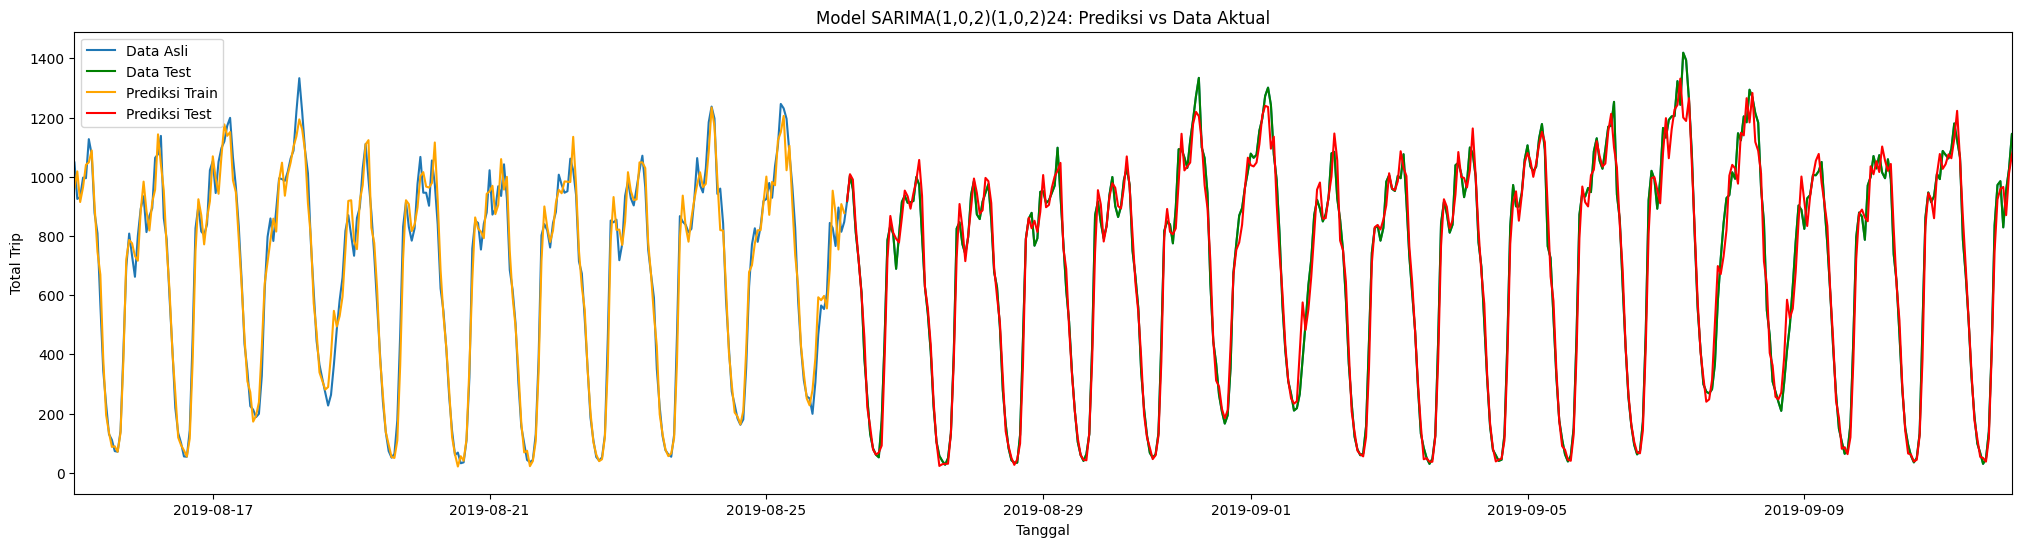

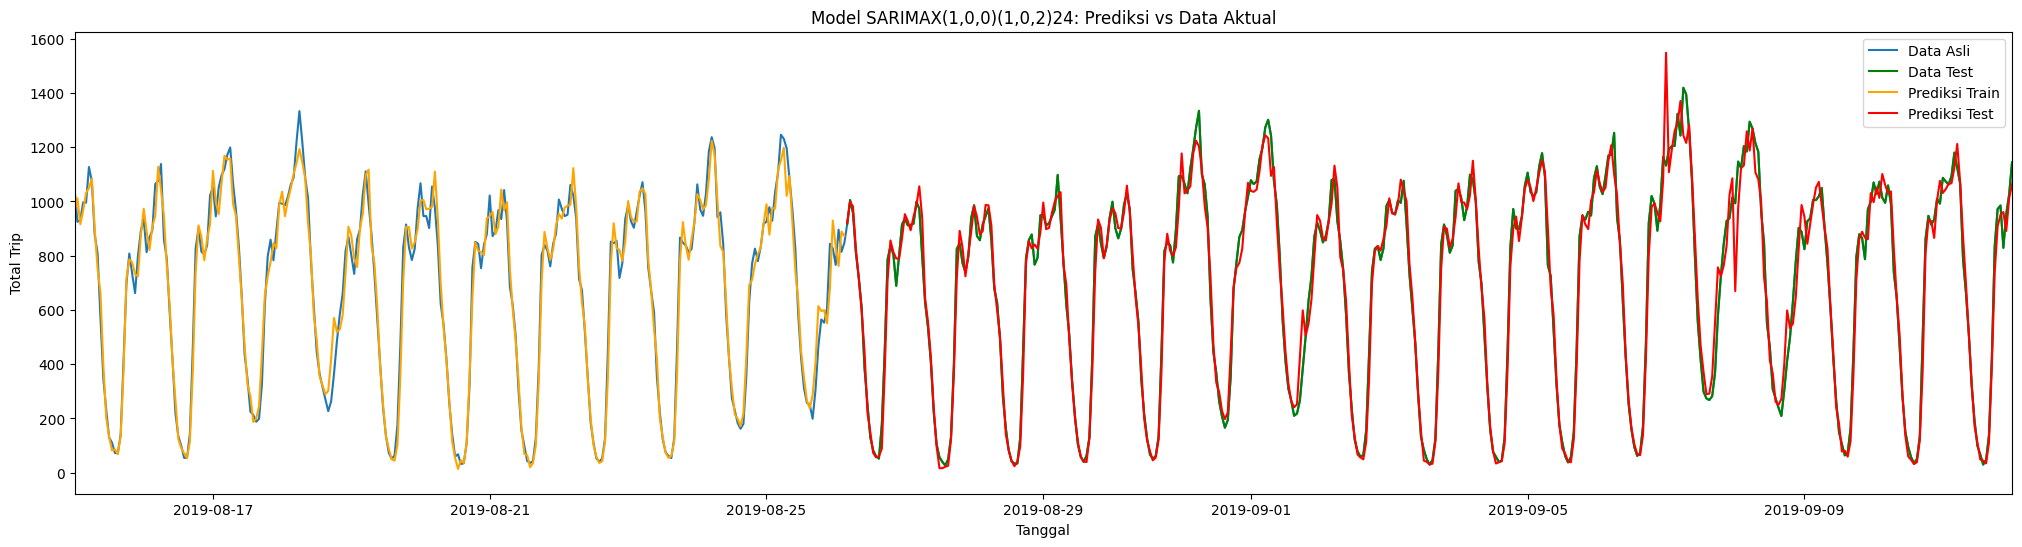

In [23]:
all_prediction_train = []
all_prediction_test = []
for i in range(len(all_fit_models)):
    if i == 0:
        prediction_train = all_fit_models[i].predict(start=df_train.index[0], end=df_train.index[-1])
        prediction_test = all_fit_models[i].predict(start=df_test.index[0], end=df_test.index[-1])
    else:
        prediction_train = all_fit_models[i].predict(start=df_train.index[0], end=df_train.index[-1], exog=df_test[['holiday', 'is_weekend']])
        prediction_test = all_fit_models[i].predict(start=df_test.index[0], end=df_test.index[-1], exog=df_test[['holiday', 'is_weekend']])
    all_prediction_train.append(prediction_train)
    all_prediction_test.append(prediction_test)
    # Plot prediksi dan data aktual
    plt.figure(figsize=(25, 6))
    plt.plot(df['total_trip'], label='Data Asli')
    plt.plot(df_test.index, df_test['total_trip'], label='Data Test', color='green')    
    plt.plot(df_train.index, prediction_train, label='Prediksi Train', color='orange')
    plt.plot(df_test.index, prediction_test, label='Prediksi Test', color='red')
    start_date = datetime.strptime('2019-08-15', '%Y-%m-%d')
    end_date = datetime.strptime('2019-09-12', '%Y-%m-%d')
    plt.xlim(start_date, end_date)
    plt.title(f'Model {nama_model[i]}: Prediksi vs Data Aktual')
    plt.xlabel('Tanggal')
    plt.ylabel('Total Trip')
    plt.legend()
    plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Hitung metrik evaluasi
for i in range(len(all_prediction_train)):
    print("Model",nama_model[i])
    rmse_train = np.sqrt(mean_squared_error(df_train['total_trip'], all_prediction_train[i])) ; rmse_test = np.sqrt(mean_squared_error(df_test['total_trip'], all_prediction_test[i]))
    mape_train = mean_absolute_percentage_error(df_train['total_trip'], all_prediction_train[i]) ; mape_test = mean_absolute_percentage_error(df_test['total_trip'], all_prediction_test[i])
    print(f"RMSE Train: {rmse_train} ; RMSE Test: {rmse_test}")
    print(f"MAPE Train: {mape_train} ; MAPE Test: {mape_test}")
    print("======================================================")

Model SARIMA(1,0,2)(1,0,2)24
RMSE Train: 59.31633906277708 ; RMSE Test: 58.45403884447503
MAPE Train: 0.09320878601421527 ; MAPE Test: 0.08685607050915549
Model SARIMAX(1,0,0)(1,0,2)24
RMSE Train: 60.56576167303726 ; RMSE Test: 62.52370425734024
MAPE Train: 0.09691941895846552 ; MAPE Test: 0.09209914600773461


# Generate tanggal untuk forecasting

In [32]:
import datetime

# Create a date range starting from September 24, 2019 to September 26, 2019
date_range = pd.date_range(start='2019-09-24', end='2019-09-26', freq='H')

# Create a DataFrame with the date range and columns for is_weekend and holiday
data_forecast = pd.DataFrame(index=date_range, columns=['is_weekend', 'holiday'])

# Fill in the is_weekend and holiday columns
for date in data_forecast.index:
    if date.weekday() >= 5:  # If Saturday or Sunday
        data_forecast.loc[date, 'is_weekend'] = 1
    else:
        data_forecast.loc[date, 'is_weekend'] = 0

    if np.random.rand() < 0.0001:  # Assume 1% of days are holidays
        data_forecast.loc[date, 'holiday'] = 1
    else:
        data_forecast.loc[date, 'holiday'] = 0
        
    data_forecast.loc[date, 'total_trip'] = ''

# Convert columns to integer type
data_forecast['is_weekend'] = data_forecast['is_weekend'].astype(int)
data_forecast['holiday'] = data_forecast['holiday'].astype(int)

## Forecasting

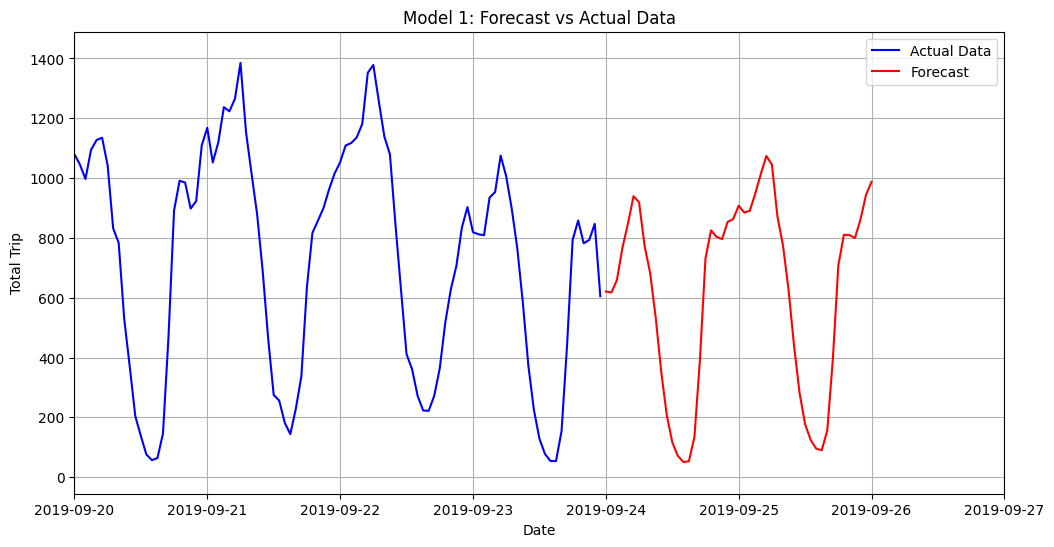

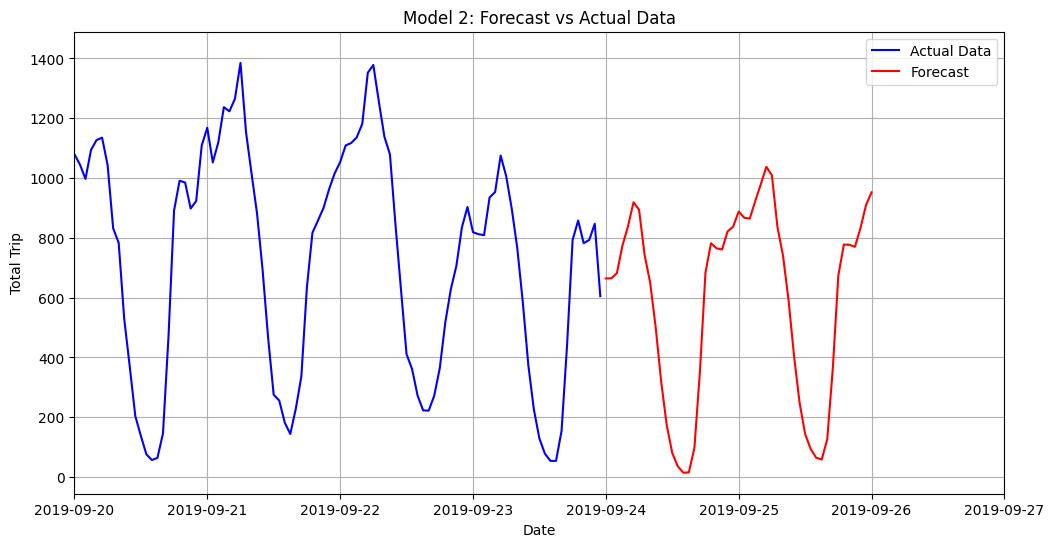

In [35]:
all_forecast = []
for i in range(len(all_fit_models)):
    if i==0:
        forecast = all_fit_models[i].forecast(steps=49)
    else:
        forecast = all_fit_models[i].forecast(steps=49, exog=data_forecast[['holiday','is_weekend']])
    all_forecast.append(forecast)
    # Plot the forecast along with the actual data
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['total_trip'], label='Actual Data', color='blue')
    plt.plot(data_forecast.index, forecast, label='Forecast', color='red')
    plt.title(f'Model {i+1}: Forecast vs Actual Data')
    start_date = datetime.strptime('2019-09-20', '%Y-%m-%d')
    end_date = datetime.strptime('2019-09-27', '%Y-%m-%d')
    plt.xlim(start_date, end_date)
    plt.xlabel('Date')
    plt.ylabel('Total Trip')
    plt.legend()
    plt.grid(True)
    plt.show()

# Eksport Data

In [40]:
df_train['prediction_SARIMA'] = all_prediction_train[0]
df_test['prediction_SARIMA'] = all_prediction_test[0]
df_train['prediction_SARIMAX'] = all_prediction_train[1]
df_test['prediction_SARIMAX'] = all_prediction_test[1]

C:\Users\ramad\AppData\Local\Temp\ipykernel_14360\3550318382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction_SARIMA'] = all_prediction_train[0]
C:\Users\ramad\AppData\Local\Temp\ipykernel_14360\3550318382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction_SARIMA'] = all_prediction_test[0]
C:\Users\ramad\AppData\Local\Temp\ipykernel_14360\3550318382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [41]:
data_forecast['prediction_SARIMA'] = all_forecast[0]
data_forecast['prediction_SARIMAX'] = all_forecast[1]

In [42]:
all_data = pd.concat([df_train,df_test,data_forecast])

In [43]:
all_data

,total_trip,holiday,is_weekend,prediction_SARIMA,prediction_SARIMAX
2019-05-03 00:00:00,988,0,0,0.000000,0.000000
2019-05-03 01:00:00,899,0,0,883.269606,891.227395
2019-05-03 02:00:00,856,0,0,782.316090,812.899422
2019-05-03 03:00:00,933,0,0,742.032021,775.741792
2019-05-03 04:00:00,987,0,0,830.303372,845.743304
...,...,...,...,...,...
2019-09-25 20:00:00,,0,0,809.637247,776.910022
2019-09-25 21:00:00,,0,0,799.555614,769.965203
2019-09-25 22:00:00,,0,0,861.037390,832.443472
2019-09-25 23:00:00,,0,0,943.890083,909.546829


In [44]:
all_data.to_csv(PATH_DATA_CLEAN+'trip_hourly_prediction_dashboard.csv')